In [1]:
import pandas as pd                                   # file reading and manipulation
import numpy as np                                    # array creation and manipulation
import requests
import json
import pickle
import skfuzzy                                        # fuzzy logic library
from skfuzzy import control as ctrl                   # fuzzy logic
from sklearn.model_selection import train_test_split  # train/test split
from sklearn.linear_model import LogisticRegression   # Logistic Regression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score            # evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import graphviz                                       # visualization
import matplotlib.pyplot as plt                       # plotting

## Preprocessing

In [2]:
df = pd.read_excel("../data/Weather based food choices (Responses).xlsx")

x = df['Dish name'].to_list()
x1 = df['Time of Day'].str.split(', ')
x2 = df['Season'].str.split(', ')

r = []
for i in range(len(x)):
    for j in range(len(x1[i])):
        for k in range(len(x2[i])):
            r.append([
                x[i],
                x1[i][j].replace('_', ' '),
                x2[i][k].replace('_', ' ')
            ])

## Training the Logistic Regression Model

In [5]:
dataset = pd.DataFrame(r, columns=['dish', 'meal', 'season'])
dataset.to_csv('../data/data.csv')

data_dict = {}
dataset['dish'], data_dict['dish'] = pd.factorize(dataset['dish'])
dataset['season'], data_dict['season'] = pd.factorize(dataset['season'])
dataset['meal'], data_dict['meal'] = pd.factorize(dataset['meal'])

for key, val in data_dict.items():
    data_dict[key] = list(val)

pd.Series(data_dict).to_json("data_dict.json")

dataset

,dish,meal,season
0,0,0,0
1,0,0,1
2,0,0,2
3,0,0,3
4,0,1,0
...,...,...,...
259,56,2,0
260,56,1,0
261,57,0,0
262,57,2,0


In [6]:
y = dataset.pop('dish').to_numpy()
x = dataset.to_numpy()

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.33,
    random_state=0,
    stratify=y
)

print('Training inputs: ', x_train.shape)
print('Testing inputs: ', x_test.shape)
print('Training outputs: ', y_train.shape)
print('Testing outputs: ', y_test.shape)

Training inputs:  (176, 2)
Testing inputs:  (88, 2)
Training outputs:  (176,)
Testing outputs:  (88,)


In [12]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=10
).fit(x_train, y_train)
rf.score(x_test, y_test), rf.score(x_train, y_train), rf.score(x, y)

(0.011363636363636364, 0.13068181818181818, 0.09090909090909091)

In [57]:
filename = 'rf.sav'
pickle.dump(rf, open(filename, 'wb'))

In [63]:
lr = LogisticRegression(
    multi_class='multinomial',
    max_iter=1000,
    solver='newton-cg',
    random_state=0
).fit(x_train, y_train)
lr.score(x_test, y_test), lr.score(x_train, y_train), lr.score(x, y)

(0.03409090909090909, 0.10795454545454546, 0.08333333333333333)

In [64]:
filename = 'lr.sav'
pickle.dump(lr, open(filename, 'wb'))

## Creating Fuzzy Variables

C:\Users\ikath\AppData\Roaming\Python\Python310\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


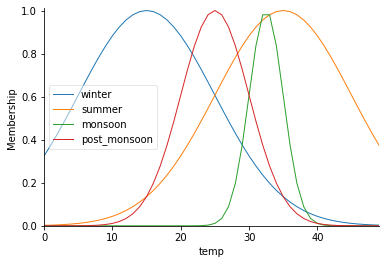

In [3]:
temp = ctrl.Antecedent(np.arange(0, 50, 1), 'temp')
temp['winter'] = skfuzzy.gaussmf(temp.universe, 15, 10)
temp['summer'] = skfuzzy.gaussmf(temp.universe, 35, 10)
temp['monsoon'] = skfuzzy.gaussmf(temp.universe, 32.5, 2.5)
temp['post_monsoon'] = skfuzzy.gaussmf(temp.universe, 25, 5)

temp.view()

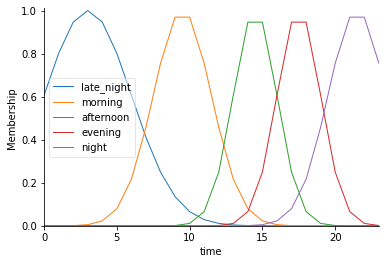

In [4]:
time = ctrl.Antecedent(np.arange(0, 24, 1), 'time')
time['late_night'] = skfuzzy.gaussmf(time.universe, 3, 3)
time['morning'] = skfuzzy.gaussmf(time.universe, 9.5, 2)
time['afternoon'] = skfuzzy.gaussmf(time.universe, 14.5, 1.5)
time['evening'] = skfuzzy.gaussmf(time.universe, 17.5, 1.5)
time['night'] = skfuzzy.gaussmf(time.universe, 21.5, 2)

time.view()

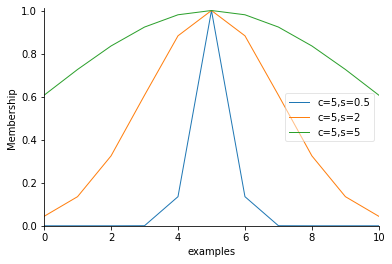

In [18]:
ex = ctrl.Antecedent(np.arange(0, 11, 1), 'examples')
ex['c=5,s=0.5'] = skfuzzy.gaussmf(ex.universe, 5, 0.5)
ex['c=5,s=2'] = skfuzzy.gaussmf(ex.universe, 5, 2)
ex['c=5,s=5'] = skfuzzy.gaussmf(ex.universe, 5, 5)

ex.view()

In [ ]:
def fuzzify_input(curr_temperature, curr_time):
    winter_fuzzy = skfuzzy.interp_membership(
        temp.universe, temp['winter'].mf, curr_temperature
    )
    monsoon_fuzzy = skfuzzy.interp_membership(
        temp.universe, temp['monsoon'].mf, curr_temperature
    )
    summer_fuzzy = skfuzzy.interp_membership(
        temp.universe, temp['summer'].mf, curr_temperature
    )
    spring_fuzzy = skfuzzy.interp_membership(
        temp.universe, temp['spring'].mf, curr_temperature
    )
    autumn_fuzzy = skfuzzy.interp_membership(
        temp.universe, temp['autumn'].mf, curr_temperature
    )

    season = {
        'winter': winter_fuzzy, 'monsoon': monsoon_fuzzy, 'summer': summer_fuzzy,
        'spring': spring_fuzzy, 'autumn': autumn_fuzzy
    }

    late_night_fuzzy = skfuzzy.interp_membership(
        time.universe, time['late_night'].mf, curr_time
    )
    morning_fuzzy = skfuzzy.interp_membership(
        time.universe, time['morning'].mf, curr_time
    )
    afternoon_fuzzy = skfuzzy.interp_membership(
        time.universe, time['afternoon'].mf, curr_time
    )
    evening_fuzzy = skfuzzy.interp_membership(
        time.universe, time['evening'].mf, curr_time
    )
    night_fuzzy = skfuzzy.interp_membership(
        time.universe, time['night'].mf, curr_time
    )

    meal = {
        'late_night': late_night_fuzzy, 'morning': morning_fuzzy,
        'afternoon': afternoon_fuzzy, 'evening': evening_fuzzy, 'night': night_fuzzy
    }

    return max(season, key=lambda x: season[x]), max(meal, key=lambda x: meal[x])

In [ ]:
cals = ctrl.Consequent(np.arange(0, 1000, 1), 'calories')
cals['very_low'] = skfuzzy.gaussmf(cals.universe, 150, 50)
cals['low'] = skfuzzy.gaussmf(cals.universe, 350, 50)
cals['mid'] = skfuzzy.gaussmf(cals.universe, 550, 50)
cals['high'] = skfuzzy.gaussmf(cals.universe, 750, 50)

cals.view()

In [ ]:
# WINTER ---------------------------------------------------------
r1 = ctrl.Rule(
    temp['winter'] | time['late_night'], cals['very_low']
)
r2 = ctrl.Rule(
    temp['winter'] | time['morning'], cals['very_low']
)
r3 = ctrl.Rule(
    temp['winter'] | time['afternoon'], cals['very_low']
)
r4 = ctrl.Rule(
    temp['winter'] | time['evening'], cals['very_low']
)
r5 = ctrl.Rule(
    temp['winter'] | time['night'], cals['very_low']
)

# MONSOON --------------------------------------------------------
r6 = ctrl.Rule(
    temp['monsoon'] | time['late_night'], cals['very_low']
)
r7 = ctrl.Rule(
    temp['monsoon'] | time['morning'], cals['very_low']
)
r8 = ctrl.Rule(
    temp['monsoon'] | time['afternoon'], cals['very_low']
)
r9 = ctrl.Rule(
    temp['monsoon'] | time['evening'], cals['very_low']
)
r10 = ctrl.Rule(
    temp['monsoon'] | time['night'], cals['very_low']
)

# SUMMER ---------------------------------------------------------
r11 = ctrl.Rule(
    temp['summer'] | time['late_night'], cals['very_low']
)
r12 = ctrl.Rule(
    temp['summer'] | time['morning'], cals['very_low']
)
r13 = ctrl.Rule(
    temp['summer'] | time['afternoon'], cals['very_low']
)
r14 = ctrl.Rule(
    temp['summer'] | time['evening'], cals['very_low']
)
r15 = ctrl.Rule(
    temp['summer'] | time['night'], cals['very_low']
)

# SPRING ----------------------------------------------------------
r16 = ctrl.Rule(
    temp['spring'] | time['late_night'], cals['very_low']
)
r17 = ctrl.Rule(
    temp['spring'] | time['morning'], cals['very_low']
)
r18 = ctrl.Rule(
    temp['spring'] | time['afternoon'], cals['very_low']
)
r19 = ctrl.Rule(
    temp['spring'] | time['evening'], cals['very_low']
)
r20 = ctrl.Rule(
    temp['spring'] | time['night'], cals['very_low']
)

# AUTUMN ---------------------------------------------------------
r21 = ctrl.Rule(
    temp['autumn'] | time['late_night'], cals['very_low']
)
r22 = ctrl.Rule(
    temp['autumn'] | time['morning'], cals['very_low']
)
r23 = ctrl.Rule(
    temp['autumn'] | time['afternoon'], cals['very_low']
)
r24 = ctrl.Rule(
    temp['autumn'] | time['evening'], cals['very_low']
)
r25 = ctrl.Rule(
    temp['autumn'] | time['night'], cals['very_low']
)

In [ ]:
menu_ctrl = ctrl.ControlSystem([
    r1, r2, r3, r4, r5, r6, r7, r8, r9, r10,
    r11, r12, r13, r14, r15, r16, r17, r18,
    r19, r20, r21, r22, r23, r24, r25
])
menu = ctrl.ControlSystemSimulation(menu_ctrl)

In [ ]:
menu.input['temp'] = curr_temperature
menu.input['time'] = curr_time

menu.compute()
menu.output['calories']